Trong thực tế việc kết hợp nhiều mô hình dự đoán (regressors hoặc classifiers), ta thường thu được kết quả tốt hơn một mô hình dự đoán đơn lẻ. Một nhóm của mô hình dự đoán đó được gọi là `ensemble` (quần thể), công nghệ này được gọi là `ensemble learning` (học tổng hợp), và một thuật toán học tổng hợp được gọi là `ensemble method`

Một ví dụ của `ensemble method`, ta có thể huấn luyện một nhóm `decision tree classifiers`, mỗi mô hình trên một bộ dữ liệu con ngẫu nhiên. Ta sẽ thu được các dự đoán của từng cây, và nhãn là lớp được dự đoán nhiều nhất. Như vậy một nhóm các cây quyết định được gọi là một `random forest`, mặc dù có vẻ đơn giản, đây là một trong những thuật toán học máy mạnh mẽ nhất hiện nay.

# Voting Classifiers

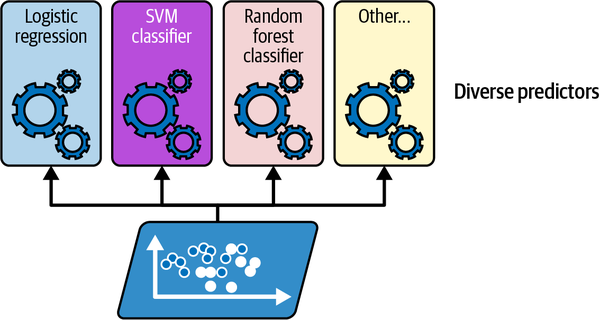

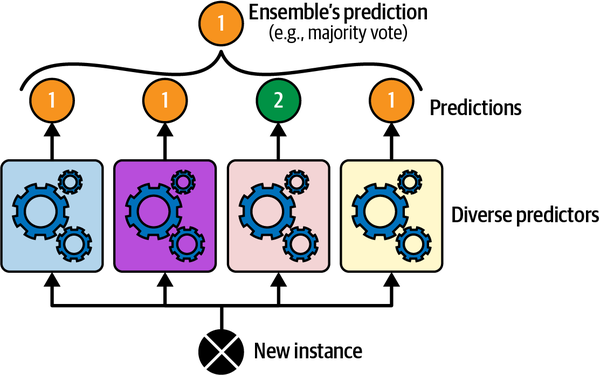

Giả sử một bộ phân loại được cấu thành từ nhiều bộ phân loại con khác, khi dự đoán kết quả là đa số kết quả của các bộ phân loại con điều này gọi là `hard voting` classifier

Một cách thần kì, voting classifier thường đạt được độ chính xác tốt hơn bộ phân loại tốt nhất trong cụm. Thực vậy, mặc dù mỗi classifier là một `weak learner` (tức là nó chỉ tốt hơn đoán ngẫu nhiên một chút), cụm này vẫn có thể là một `strong learner` (độ chính xác cao) miễn là số weak learner đủ nhiều và đa dạng.

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [2]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [4]:
voting_clf.score(X_test, y_test)

0.912

Nếu các classifiers có thể dự đoán xác suất, ta có thể dự đoán theo xác suất cao nhất, gọi là `soft voting`. Nó thường có hiệu suất tốt hơn `hard voting` bởi nó cùng cấp nhiều trọng số hơn để dự đoán.

In [5]:
voting_clf.voting = 'soft'
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting

Một cách để có được một tập hợp đa dạng các bộ phân loại là sử dụng các thuật toán huấn luyện rất khác nhau. Một cách tiếp cần khác là sử dụng một loại thuật toán huấn luyện cho tất cả các bộ dự đoán nhưng đào tạo chúng trên các tập con ngẫu nhiên khác nhau của training set.

Khi việc lấy mẫu được thực hiện có hoàn lại (tức là một mẫu có thể bị lấy nhiều lần), phương pháp này được gọi là `bagging` (viết tắt của bootstrap aggregating). Khi lấy mẫu không hoàn lại thì được gọi là `pasting`. 

Nói cách khác, cả bagging và pasting đều cho phép các mẫu huấn luyện được chọn nhiều lần giữa các bộ dự đoán khác nhau, nhưng chỉ bagging mới cho phép một mẫu huấn luyện được chọn nhiều lần trong cùng một bộ dự đoán.

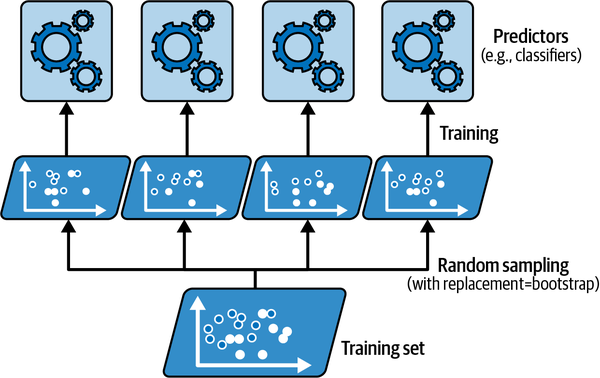

Khi tất cả các bộ dự đoán được huấn luyện, cụm có thể dự đoán một instance mới bằng cách kết hợp các dự đoán của bộ dự đoán. Hàm kết hợp thường được sử dụng là thống kê (statistical mode) cho phân loại, hoặc trung bình cho hồi quy. Mỗi bộ dự đoán riêng lẻ sẽ có độ lệch (bias) cao hơn so với khi nó được huấn luyện trên toàn bộ tập huấn luyện gốc, nhưng việc tổng hợp (aggregation) giúp giảm cả bias và phương sai (variance).
Nhìn chung, kết quả cuối cùng là mô hình tổ hợp (ensemble) có độ lệch tương đương nhưng phương sai thấp hơn so với một bộ dự đoán đơn lẻ được huấn luyện trên tập huấn luyện gốc.

Từ hình trên có thể thấy các bộ dự đoán có thể được huấn luyện song song cùng một lúc. Đó là lí do tại sao bagging và pasting được sử dụng phổ biến, vì nó có thể mở rộng rất tốt.

In [ ]:
Từ hình trên c